# Modelling Brand Choice Probability

In this notebook, we explore how to model brand choice probability. In other words, we want to know which of the available brands will a customer buy, given that the customer already decided to buy a product from a specific product category. The main objective to develop a statistical model which estimate brand probability for each shopping trip based on historical purchase data. The resulting model can help marketers analyse the behaviour of their customers leading to an increase in customer satisfaction and a boost in sales.

## Code

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

import plotly.express as px

sns.set(style='whitegrid')

In [2]:
df_purchases = pd.read_csv('data/fmcg-store-purchases-augmented.csv', index_col=0)

segment_labels = pickle.load(open('models/segment-labels.pickle', 'rb'))
segment_colours = ['lightskyblue', 'red', 'gold', 'green']
segment_colour_palette = sns.color_palette(segment_colours)

In [3]:
def calc_brand_price_elasticity(df: pd.DataFrame, brand: int, price_range=(0.5, 3.5)):
    # We are only interested in rows where customer bought one of more chocolates
    df_data = df[df['Incidence'] == 1]
    
    # For now, we assume that only the price features effect the choice of brand,
    # although other features such as promotion may also have an effect.
    features = [f'Price_{i}' for i in range(1, 6)]
    X = df_filtered_data[features]
    y = df_filtered_data['Brand']
    
    # Fit a model
    lr = LogisticRegression(solver='sag')
    lr.fit(X, y)
    
    # Generate the test data
    price_range_arr = np.arange(price_range[0], price_range[1], 0.01).reshape(-1, 1)
    df_test_data = pd.DataFrame(index=np.arange(price_range_arr.shape[0]))
    
    for i in range(1, 6):
        if i != brand:
            # Fix the price of other brands to their mean
            df_test_data[f'Price_{i}'] = np.mean(df_data[f'Price_{i}'])
        else:
            # Vary the prices of the brand of interest
            df_test_data[f'Price_{i}'] = price_range_arr
    
    # Generate probabilities for all the brands given the test data
    y_preds = lr.predict_proba(df_test_data)
    
    # The prediction matrix `y_preds` has the shape (n_rows, n_classes).
    # Extract probabilities for the chosen brand.
    brand_proba = y_preds[:][:, brand-1].reshape(-1, 1)
    
    # Find the price coefficient for the chosen brand
    price_brand_coeff = lr.coef_[brand-1, brand-1]
    
    # Compute the elasticity
    price_elasticity = price_brand_coeff * price_range_arr * (1 - brand_proba)
    
    elasticity_data = np.concatenate([price_range_arr, price_elasticity], axis=1)
    df_elasticities = pd.DataFrame(elasticity_data, columns=['Price', 'Elasticity'])
    
    return df_elasticities
    

## Multinomial Logistic Regression Model

In [4]:
# We are only interested in rows where customer bought one of more chocolates
df_filtered_data = df_purchases[df_purchases['Incidence'] == 1]

In [5]:
# For now, we assume that only the price features effect the choice of brand,
# although other features such as promotion may also have an effect.
features = [f'Price_{i}' for i in range(1, 6)]

X = df_filtered_data[features]
y = df_filtered_data['Brand']

In [6]:
# Fit a model
lr = LogisticRegression(solver='sag')
lr.fit(X, y)

# The coef_ returns the coefficient of the features in the decision function.
# It is an Numpy array with shape (n_classes, n_features). Let us create
# a DataFrame to be better able to interpret the results.
df_coeffients = pd.DataFrame(
    lr.coef_,
    index=[f'Brand {i}' for i in range(1, 6)], 
    columns=[f'Price {i}' for i in range(1, 6)]
)

In [7]:
df_coeffients.T.round(2)

,Brand 1,Brand 2,Brand 3,Brand 4,Brand 5
Price 1,-3.92,1.27,1.62,0.57,0.44
Price 2,0.66,-1.88,0.56,0.40,0.26
Price 3,2.42,-0.21,0.50,-1.40,-1.31
Price 4,0.70,-0.21,1.04,-1.25,-0.29
Price 5,-0.20,0.59,0.45,0.25,-1.09


As an example, let us consider Brand 1. The coefficient of Brand 1 w.r.t. its price is negative. We already know that the higher price of our own product, the lower the purchase probability. So it makes sense the price to be negative. We also observe that the coefficient is positive for Price 2, 3 and 4. There is a positive relationship between our Brand 1's purchase probability and competitor brands 2-4 increasing their prices. So if these brands increase their prices, the higher is the likelihood that consumers switching to Brand 1.

The band choice probability of any brand compared to the other brands are interrelated. The marketing mix tool of our brand reflects, not only the choice probability of our brand, but the choice probabilities for all other brands as well. These effects are known as own brand and cross brand effects. We can examine these effects when we calculate their respective elasticities.

Suppose we are working for Brand 5 so we are mostly interested in knowing the effects of price changes to Brand 5 (Own Price Elasticity). It would also be interesting to find out what would happen if the competitors change their prices (Cross Price Elasticity).

## Own Price Elasticty for Brand 5

Let us focus on the most expensive brand and create own price elasticity.

In [8]:
df_brand_5_elasticities = calc_brand_price_elasticity(df_purchases, brand=5)

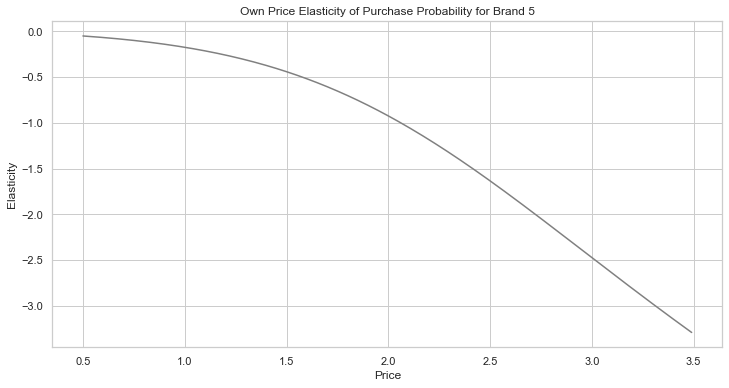

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x='Price', y='Elasticity', data=df_brand_5_elasticities, color='grey', ax=ax)
ax.set_title('Own Price Elasticity of Purchase Probability for Brand 5');